In [1]:
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle


import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
'''
from multiprocessing import Pool
from multiprocessing import cpu_count
import emcee
from tqdm import tqdm

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
'''

'\nfrom multiprocessing import Pool\nfrom multiprocessing import cpu_count\nimport emcee\nfrom tqdm import tqdm\n\nncpu = cpu_count()\nprint("{0} CPUs".format(ncpu))\n'

In [4]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

In [5]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [6]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [7]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def K(n):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1],2*np.ones(n-2),[1]))
    return tridiag(upper,center,upper)

def covHO(n,a):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1+a**2],(2+a**2)*np.ones(n-2),[1+a**2]))
    return np.linalg.inv(1/a*tridiag(upper,center,upper))

def solveHOE(t,a,b,T):
    t=np.array(t)
    return a*cosh(t) + (-a*cosh(T)/sinh(T) + b/sinh(T))*sinh(t)

In [8]:
def V_AHO(x):
    return -x**2/2-x+x**4/16

def lnprob_V(x, n, a):
    return -np.dot(x,np.dot(K(n),x))/2.0/a - np.sum(a*V_AHO(x))

In [9]:
T = 2

In [10]:
'''
T = 2
n_slice = 40
beta = 1/T
a = beta/n_slice
n_tsteps = 1000000
nwalkers = 100


path0 = np.random.rand(n_slice * nwalkers).reshape((nwalkers, n_slice))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, n_slice, lnprob_V, args = [n_slice, a], pool=pool)
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    pos, prob, state = sampler.run_mcmc(path0, 1000, progress=False)
    sampler.reset()
    
    sampler.run_mcmc(pos, n_tsteps, progress = False)
    paths = sampler.get_chain(flat = True)
    sampler.reset() 
'''

'\nT = 2\nn_slice = 40\nbeta = 1/T\na = beta/n_slice\nn_tsteps = 1000000\nnwalkers = 100\n\n\npath0 = np.random.rand(n_slice * nwalkers).reshape((nwalkers, n_slice))\nwith Pool() as pool:\n    sampler = emcee.EnsembleSampler(nwalkers, n_slice, lnprob_V, args = [n_slice, a], pool=pool)\n    #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)\n    pos, prob, state = sampler.run_mcmc(path0, 1000, progress=False)\n    sampler.reset()\n    \n    sampler.run_mcmc(pos, n_tsteps, progress = False)\n    paths = sampler.get_chain(flat = True)\n    sampler.reset() \n'

In [12]:
from torch.utils.data import Dataset, DataLoader

class PathData(Dataset):
    def __init__(self, in_x, in_y):
        
        if not torch.is_tensor(in_x):
            self.in_x = torch.from_numpy(in_x)
        else:
            self.in_x = in_x
            
        if not torch.is_tensor(in_y):
            self.in_y = torch.from_numpy(in_y)
        else:
            self.in_y = in_y
        
        self.len = len(self.in_x)
        
    def __getitem__(self,index):    
            
        return self.in_x[index], self.in_y[index]
    
    def __len__(self):
        
        return self.len

In [13]:
class QML(nn.Module):
    def __init__(self, n_ES, n_B):
        super(QML, self).__init__()
        
        self.n_Ba = n_B
        self.n_EL = n_ES + 1
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL) - make_diag(self.n_EL) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL) > 0 #convert to boolean   
        
    def forward(self, in_x, in_y):
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC
        logits = F.softmin(self.levels, dim = 0)
        
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)
        
        loss_ML = -1 * torch.mean(torch.matmul( torch.matmul(in_x, var_BaC_N) * torch.matmul(in_y, var_BaC_N) \
                    , torch.log(logits*(10**4.)+1) ) )
        
        loss = loss_orth + loss_ML
        
        return loss, loss_ML, loss_orth, self.levels, logits 

In [14]:
def main_train_states_QML(G, in_x, in_y, batch_size = 500, epochs = 1, step = 1e-3):
    
    pathset = PathData(in_x, in_y)
    TrainLoader = DataLoader(dataset=pathset, batch_size=batch_size, shuffle = True, num_workers=2)
    
    optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    
    loss_hist = []
    loss_ML_hist = []
    loss_orth_hist = []
    
    levels_hist = []
    logits_hist = []
        
        
    
    for i in range(epochs):
        start_time = time.time()
        for id_xy, [mini_in_x, mini_in_y] in enumerate(TrainLoader):
        
            [loss, loss_ML, loss_orth, levels, logits] = G(mini_in_x, mini_in_y)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        
        
            loss_hist.append(loss.tolist())
            loss_ML_hist.append(loss_ML.tolist())
            loss_orth_hist.append(loss_orth.tolist())
        
            levels_hist.append(levels.tolist())
            logits_hist.append(logits.tolist())
            
           
        
            if id_xy % 1000 == 0:
                
                print('Batch number ', id_xy)
                print('Loss: ', loss)
                print('Loss_orth: ', loss_orth)
                print('Loss_ML: ', loss_ML)
                print('Logits: ', logits)
                
                end_time = time.time()
                print('Time taken: {0:.3f} seconds'.format(end_time - start_time))
                start_time = time.time()
                
                print('@----------------------------------------------------------@')
                #writer.add_summary(summary, i)
                #writer.flush()
                
            
        
                
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)
    logits_hist = np.array(logits_hist)
    
    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach()
    fin_logits = F.softmin(fin_EL, dim = 0)
    fin_EL = fin_EL.numpy()
    fin_logits = fin_logits.numpy()
    
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    logits_hist = logits_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    fin_logits = fin_logits[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    return loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_BaC_N, fin_EL, fin_logits

In [15]:
infile = "AHO_PI_MCMC_T" + str(T) + ".npy"
paths = np.load(infile)
print(paths.shape)

x = paths[:, 0]
y = paths[:, -1]

del paths

(100000000, 40)


In [16]:
n_Hm = 10
n_EL = 10

x = HM(n_Hm, x)
y = HM(n_Hm, y)

In [17]:


in_x = torch.from_numpy(x)
in_y = torch.from_numpy(y)

del x,y

In [18]:
#epochs = 1
qml_AHO_HM = QML(n_EL, n_Hm+1)

[loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_HC_N, levels_fin, logits_fin] = \
            main_train_states_QML(qml_AHO_HM, in_x, in_y)

/home/scl489/.env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Batch number  0
Loss:  tensor(81.4671, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(86.1912, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.7241, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.0753, 0.0995, 0.1136, 0.0994, 0.1061, 0.0688, 0.0747, 0.0541, 0.1171,
        0.1032, 0.0882], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 10.070 seconds
@----------------------------------------------------------@
Batch number  1000
Loss:  tensor(-3.9901, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0787, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.0688, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.0895, 0.1333, 0.1124, 0.0471, 0.1348, 0.0451, 0.0376, 0.0875, 0.0841,
        0.0549, 0.1736], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.675 seconds
@----------------------------------------------------------@
Batch number  2000
Loss:  tensor(-4.0581, d

Batch number  18000
Loss:  tensor(-4.8547, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0009, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.8556, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2128, 0.1160, 0.0198, 0.0049, 0.0516, 0.0013, 0.0271, 0.0697, 0.0248,
        0.0020, 0.4699], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.781 seconds
@----------------------------------------------------------@
Batch number  19000
Loss:  tensor(-4.4969, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0006, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4975, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2141, 0.1163, 0.0193, 0.0051, 0.0512, 0.0013, 0.0271, 0.0728, 0.0238,
        0.0021, 0.4672], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.040 seconds
@----------------------------------------------------------@
Batch number  20000
Loss:  tensor(-4.197

Batch number  36000
Loss:  tensor(-4.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0010, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4213, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2144, 0.1162, 0.0148, 0.0055, 0.0530, 0.0009, 0.0309, 0.0787, 0.0174,
        0.0024, 0.4659], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.127 seconds
@----------------------------------------------------------@
Batch number  37000
Loss:  tensor(-4.3362, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.3366, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2130, 0.1173, 0.0143, 0.0053, 0.0526, 0.0008, 0.0301, 0.0789, 0.0168,
        0.0024, 0.4684], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.227 seconds
@----------------------------------------------------------@
Batch number  38000
Loss:  tensor(-4.410

Batch number  54000
Loss:  tensor(-4.3261, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.3265, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2144, 0.1175, 0.0136, 0.0054, 0.0542, 0.0006, 0.0327, 0.0792, 0.0160,
        0.0025, 0.4637], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.244 seconds
@----------------------------------------------------------@
Batch number  55000
Loss:  tensor(-4.4546, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0005, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4550, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2145, 0.1166, 0.0136, 0.0051, 0.0533, 0.0006, 0.0326, 0.0793, 0.0157,
        0.0025, 0.4662], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.114 seconds
@----------------------------------------------------------@
Batch number  56000
Loss:  tensor(-4.494

Batch number  72000
Loss:  tensor(-4.4362, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0008, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4369, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2151, 0.1158, 0.0125, 0.0052, 0.0526, 0.0005, 0.0326, 0.0794, 0.0162,
        0.0025, 0.4676], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.938 seconds
@----------------------------------------------------------@
Batch number  73000
Loss:  tensor(-4.3673, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0006, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.3679, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2137, 0.1171, 0.0127, 0.0052, 0.0536, 0.0005, 0.0327, 0.0789, 0.0162,
        0.0025, 0.4668], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.932 seconds
@----------------------------------------------------------@
Batch number  74000
Loss:  tensor(-4.394

Batch number  90000
Loss:  tensor(-4.4132, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4136, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2143, 0.1166, 0.0123, 0.0053, 0.0536, 0.0006, 0.0326, 0.0792, 0.0175,
        0.0025, 0.4654], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.939 seconds
@----------------------------------------------------------@
Batch number  91000
Loss:  tensor(-4.5995, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0012, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.6007, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2142, 0.1172, 0.0118, 0.0053, 0.0525, 0.0006, 0.0329, 0.0790, 0.0172,
        0.0025, 0.4668], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.945 seconds
@----------------------------------------------------------@
Batch number  92000
Loss:  tensor(-4.382

Batch number  108000
Loss:  tensor(-4.4535, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4540, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2136, 0.1169, 0.0111, 0.0054, 0.0529, 0.0005, 0.0327, 0.0800, 0.0185,
        0.0025, 0.4659], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.958 seconds
@----------------------------------------------------------@
Batch number  109000
Loss:  tensor(-4.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0005, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.2434, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2133, 0.1178, 0.0111, 0.0054, 0.0531, 0.0005, 0.0320, 0.0797, 0.0186,
        0.0026, 0.4659], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.931 seconds
@----------------------------------------------------------@
Batch number  110000
Loss:  tensor(-4.

Batch number  126000
Loss:  tensor(-4.5403, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.5407, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2157, 0.1174, 0.0105, 0.0051, 0.0530, 0.0005, 0.0325, 0.0799, 0.0186,
        0.0027, 0.4642], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.857 seconds
@----------------------------------------------------------@
Batch number  127000
Loss:  tensor(-4.4440, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.4444, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2143, 0.1164, 0.0107, 0.0052, 0.0532, 0.0006, 0.0324, 0.0797, 0.0186,
        0.0027, 0.4663], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.845 seconds
@----------------------------------------------------------@
Batch number  128000
Loss:  tensor(-4.

Batch number  144000
Loss:  tensor(-4.1344, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.1348, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2143, 0.1168, 0.0107, 0.0050, 0.0537, 0.0005, 0.0329, 0.0800, 0.0187,
        0.0025, 0.4650], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.122 seconds
@----------------------------------------------------------@
Batch number  145000
Loss:  tensor(-4.2246, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0006, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.2252, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2146, 0.1177, 0.0107, 0.0052, 0.0532, 0.0005, 0.0325, 0.0801, 0.0189,
        0.0025, 0.4639], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.134 seconds
@----------------------------------------------------------@
Batch number  146000
Loss:  tensor(-4.

Batch number  162000
Loss:  tensor(-4.6590, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0003, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.6593, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2141, 0.1174, 0.0106, 0.0054, 0.0529, 0.0006, 0.0317, 0.0804, 0.0187,
        0.0026, 0.4657], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.117 seconds
@----------------------------------------------------------@
Batch number  163000
Loss:  tensor(-4.5167, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0006, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.5173, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2130, 0.1170, 0.0105, 0.0054, 0.0528, 0.0006, 0.0325, 0.0803, 0.0188,
        0.0025, 0.4666], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.104 seconds
@----------------------------------------------------------@
Batch number  164000
Loss:  tensor(-4.

Batch number  180000
Loss:  tensor(-4.6502, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.6506, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2149, 0.1179, 0.0106, 0.0051, 0.0538, 0.0005, 0.0328, 0.0805, 0.0187,
        0.0023, 0.4629], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.077 seconds
@----------------------------------------------------------@
Batch number  181000
Loss:  tensor(-4.5885, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0003, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.5889, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2165, 0.1166, 0.0106, 0.0051, 0.0523, 0.0005, 0.0323, 0.0782, 0.0184,
        0.0022, 0.4672], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.241 seconds
@----------------------------------------------------------@
Batch number  182000
Loss:  tensor(-4.

Batch number  198000
Loss:  tensor(-4.3329, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0009, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.3338, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2147, 0.1159, 0.0107, 0.0054, 0.0531, 0.0006, 0.0329, 0.0796, 0.0190,
        0.0026, 0.4655], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.840 seconds
@----------------------------------------------------------@
Batch number  199000
Loss:  tensor(-4.3813, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss_orth:  tensor(0.0003, dtype=torch.float64, grad_fn=<MulBackward0>)
Loss_ML:  tensor(-4.3816, dtype=torch.float64, grad_fn=<MulBackward0>)
Logits:  tensor([0.2112, 0.1178, 0.0104, 0.0051, 0.0523, 0.0006, 0.0324, 0.0788, 0.0186,
        0.0024, 0.4704], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.779 seconds
@----------------------------------------------------------@


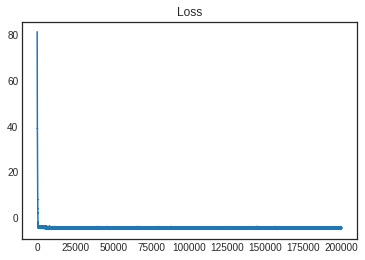

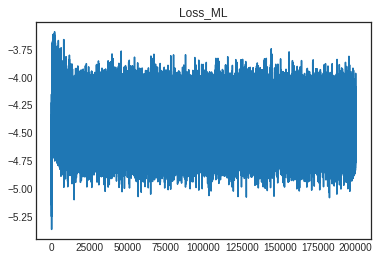

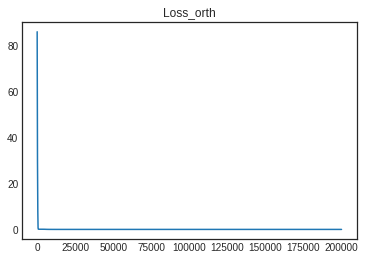

In [19]:
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(len(loss_ML_hist)), loss_ML_hist)
plt.title("Loss_ML")
plt.show()
plt.plot(np.arange(len(loss_orth_hist)), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

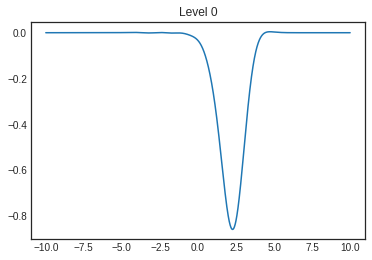

Square integrated over the region: 1.0000000000000222


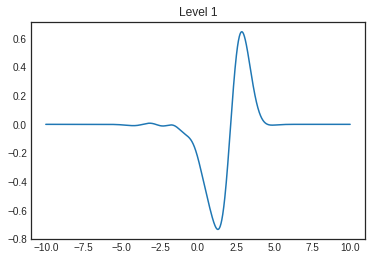

Square integrated over the region: 1.000000000000022


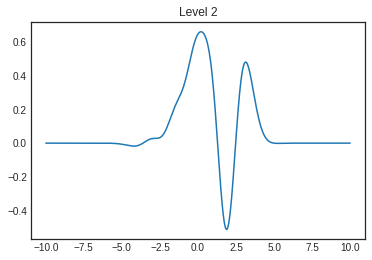

Square integrated over the region: 1.0000000000000215


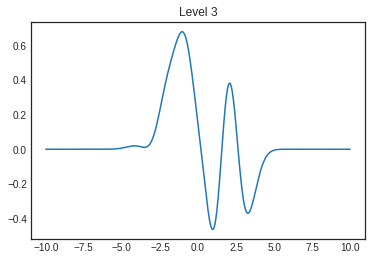

Square integrated over the region: 1.000000000000022


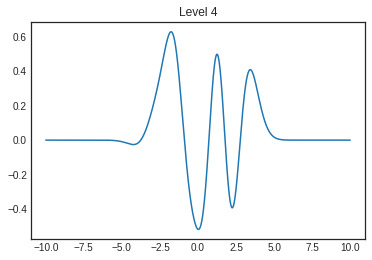

Square integrated over the region: 1.000000000000022


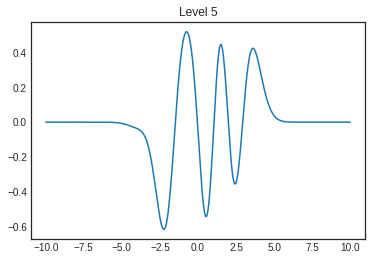

Square integrated over the region: 1.000000000000022


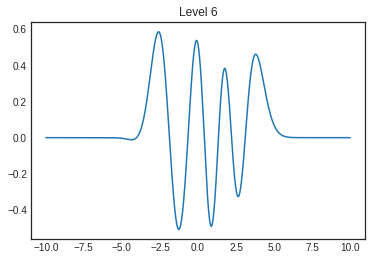

Square integrated over the region: 1.0000000000000224


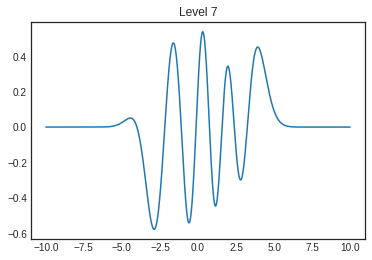

Square integrated over the region: 1.0000000000000222


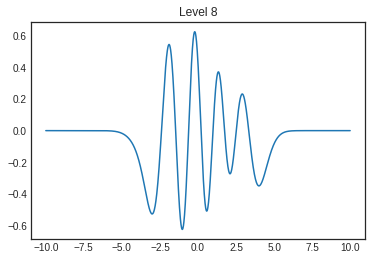

Square integrated over the region: 1.000000000000022


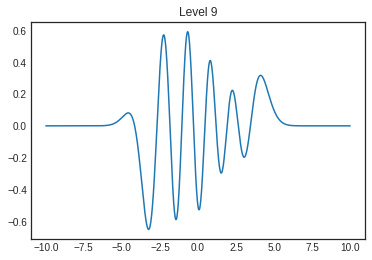

Square integrated over the region: 1.0000000000000222


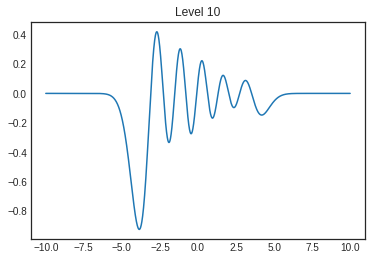

Square integrated over the region: 1.000000000000023


In [20]:
x = np.arange(-10, 10 , 0.01)

Y = HM(n_Hm, x)

SUP = np.matmul(Y, var_HC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

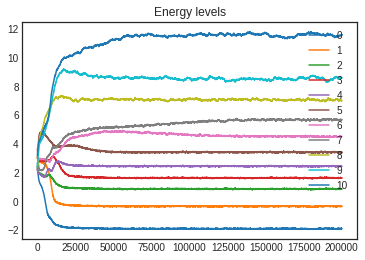

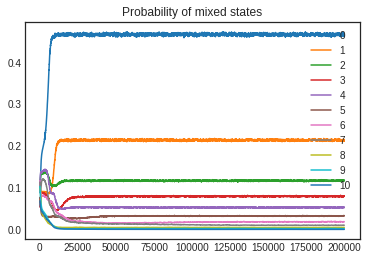

In [21]:
for i in range(n_EL+1):
    plt.plot(np.arange(len(levels_hist[:,i])), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(len(logits_hist[:,i])), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [22]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-0.94624796 -0.17907016  0.41932006  0.80108752  1.21516342  1.70705565
  2.25353607  2.83394407  3.51250689  4.30646329  5.79881152]
Probabilities: 
[0.46275909 0.21486905 0.11811262 0.08063003 0.05329248 0.03258666
 0.01886715 0.01055938 0.00535726 0.00242176 0.00054452]


In [23]:
print(np.amax(np.abs(np.matmul(var_HC_N.T, var_HC_N) - np.identity(n_EL+1))))

0.0020463345926909093
